## Import packages and set-up

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import numpy as np
import warnings
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt
import re
from gensim import corpora, models


warnings.filterwarnings('ignore')

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/wesleychoy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/wesleychoy/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/wesleychoy/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
data = pd.read_csv('bt4222_dataset_21.csv')
data.head()

,app_id,app_name,review_id,review,timestamp_updated,recommended,author.steamid,author.num_games_owned,author.playtime_at_review,Release date,...,is_free,owned_games,weighted_vote_score,votes_helpful,user_review_count,item_review_count,game_playtime_percentile,game_description,review_text_clean,pred_rating
0,4000,Garry's Mod,297534,Now you too can make your very own creepy Pose...,1290229222,True,76561197967992446,1037,287.0,"Nov 29, 2006",...,False,NaN,0.0,0,29,2247,0.064850,"Casual,Indie,Simulation Single-player,Multi-pl...",Now you too can make your very own creepy Pose...,4
1,48700,Mount & Blade: Warband,297695,All the thrill of killing groups of raiders on...,1290283941,True,76561197967992446,1037,115.0,"Mar 31, 2010",...,False,NaN,0.0,0,29,936,0.040143,"Action,RPG Single-player,Multi-player,Steam Ac...",All the thrill of killing groups of raiders on...,4
2,48700,Mount & Blade: Warband,321598,I really liked this game. You really can build...,1290984804,True,76561197968566119,587,6267.0,"Mar 31, 2010",...,False,NaN,0.0,0,23,936,0.592607,"Action,RPG Single-player,Multi-player,Steam Ac...",I really liked this game. You really can build...,4
3,35140,Batman: Arkham Asylum GOTY Edition,321586,"The story seemed awesome at first, but then it...",1291337732,True,76561197968566119,587,96.0,"Mar 26, 2010",...,False,NaN,0.0,0,23,597,0.075965,"Action,Adventure Single-player,Steam Achieveme...","The story seemed awesome at first, but then it...",2
4,240,Counter-Strike: Source,321552,awesome game. I was addicted to this for 5 years.,1291338488,True,76561197968566119,587,6277.0,"Nov 1, 2004",...,False,NaN,0.0,0,23,931,0.814495,"Action Multi-player,Cross-Platform Multiplayer...",awesome game. I was addicted to this for 5 years.,4


In [ ]:
df = data[['app_id','app_name','review','timestamp_updated','recommended','author.steamid',
            'Price','DLC count','Genres','About the game', 'is_free', 'user_review_count','item_review_count',
            'Categories','Developers','Publishers','game_playtime_percentile', 'pred_rating']]

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126144 entries, 0 to 126143
Data columns (total 18 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   app_id                    126144 non-null  int64  
 1   app_name                  126144 non-null  object 
 2   review                    126144 non-null  object 
 3   timestamp_updated         126144 non-null  int64  
 4   recommended               126144 non-null  bool   
 5   author.steamid            126144 non-null  int64  
 6   Price                     126144 non-null  float64
 7   DLC count                 126144 non-null  int64  
 8   Genres                    126144 non-null  object 
 9   About the game            126144 non-null  object 
 10  is_free                   126144 non-null  bool   
 11  user_review_count         126144 non-null  int64  
 12  item_review_count         126144 non-null  int64  
 13  Categories                126144 non-null  o

### train-test split
first 80% of reviews by user is used for train

remaining 20% used in test

In [ ]:
df = df.sort_values(by=['author.steamid','timestamp_updated'])

train_data = []
test_data = []

# early 80% for train, later 20% for test for each user
for user_id, user_df in df.groupby('author.steamid'):
    split_index = int(len(user_df) * 0.8)

    # Split into train and test
    train_data.append(user_df.iloc[:split_index])  # early 80% for training
    test_data.append(user_df.iloc[split_index:])   # later 20% for testing

train = pd.concat(train_data, ignore_index=True)
test = pd.concat(test_data, ignore_index=True)

print(f"Training set size: {len(train)}, Test set size: {len(test)}")


Training set size: 98973, Test set size: 27171


make sure users and items in the test set appear in the train set

In [ ]:
test = test[test['author.steamid'].isin(train['author.steamid'])]
test = test[test['app_id'].isin(train['app_id'])]

test.shape

(27171, 18)

In [ ]:
# encode user and item ids
user_encoder = LabelEncoder()
item_encoder = LabelEncoder()
train['user_encoded'] = user_encoder.fit_transform(train['author.steamid'])
train['item_encoded'] = item_encoder.fit_transform(train['app_id'])
test['user_encoded'] = user_encoder.transform(test['author.steamid'])
test['item_encoded'] = item_encoder.transform(test['app_id'])

# convert boolean to binary
bool_cols = df.select_dtypes(include='bool').columns.tolist()
train[bool_cols] = train[bool_cols].astype(int)
test[bool_cols] = test[bool_cols].astype(int)

## Baseline NCF


### initialise dataloaders

In [ ]:
# initalise datasets
baseline_ncf_train = train[['user_encoded','item_encoded','recommended']]
baseline_ncf_test = test[['user_encoded','item_encoded','recommended']]

In [ ]:
class SteamReviewsDatasetBase(Dataset):
    def __init__(self, df):
        self.user_ids = torch.tensor(df['user_encoded'].values, dtype=torch.long)
        self.item_ids = torch.tensor(df['item_encoded'].values, dtype=torch.long)
        self.labels = torch.tensor(df['recommended'].values, dtype=torch.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):

        return self.user_ids[idx], self.item_ids[idx], self.labels[idx]

In [ ]:
batch_size=256
train_dataset = SteamReviewsDatasetBase(train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = SteamReviewsDatasetBase(test)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

### Initalise model

In [ ]:
class NCF_Base(nn.Module):
    def __init__(self, num_users, num_items, embedding_dim):
        super(NCF_Base, self).__init__()
        self.user_embedding_gmf = nn.Embedding(num_users, embedding_dim)
        self.item_embedding_gmf = nn.Embedding(num_items, embedding_dim)
        self.user_embedding_mlp = nn.Embedding(num_users, embedding_dim)
        self.item_embedding_mlp = nn.Embedding(num_items, embedding_dim)

        self.mlp_layer1 = nn.Linear(2 * embedding_dim, 128)
        self.mlp_relu1 = nn.ReLU()

        self.mlp_layer2 = nn.Linear(128, 64)
        self.mlp_relu2 = nn.ReLU()

        self.mlp_layer3 = nn.Linear(64, 32)
        self.mlp_relu3 = nn.ReLU()

        combined_input_size = embedding_dim + 32 # GMF + last mlp layer size
        self.fc1 = nn.Linear(combined_input_size, 1)

        self.sigmoid = nn.Sigmoid()

    def forward(self, user_id, item_id):
        # GMF
        user_emb_gmf = self.user_embedding_gmf(user_id)
        item_emb_gmf = self.item_embedding_gmf(item_id)
        gmf_output = user_emb_gmf * item_emb_gmf  # element-wise multiplication

        # MLP
        user_emb_mlp = self.user_embedding_mlp(user_id)
        item_emb_mlp = self.item_embedding_mlp(item_id)

        mlp_input = torch.cat([user_emb_mlp, item_emb_mlp], dim=-1)

        # pass thru mlp layers
        mlp_output = self.mlp_layer1(mlp_input)
        mlp_output = self.mlp_relu1(mlp_output)

        mlp_output = self.mlp_layer2(mlp_output)
        mlp_output = self.mlp_relu2(mlp_output)

        mlp_output = self.mlp_layer3(mlp_output)
        mlp_output = self.mlp_relu3(mlp_output)

        # combine GMF and MLP outputs
        combined_output = torch.cat([gmf_output, mlp_output], dim=-1)
        output = self.fc1(combined_output)
        output = self.sigmoid(output)  # sigmoid for binary classification

        return output.squeeze()


### Model Training and Test Loss

In [ ]:
num_users = train['user_encoded'].nunique()
num_items = train['item_encoded'].nunique()
embedding_dim = 64
lr=0.001
num_epochs=10


ncf_baseline = NCF_Base(
    num_users=num_users,
    num_items=num_items,
    embedding_dim=embedding_dim
)

optimizer = torch.optim.Adam(ncf_baseline.parameters(), lr=lr)
criterion = nn.BCELoss()

for epoch in range(num_epochs):
    ncf_baseline.train()
    epoch_loss = 0

    for user_ids, item_ids, labels in train_loader:

        optimizer.zero_grad()
        outputs = ncf_baseline(user_ids, item_ids)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss / len(train_loader)}')


ncf_baseline.eval()
with torch.no_grad():
    total_loss = 0
    for user_ids, item_ids,labels in test_loader:

        outputs = ncf_baseline(user_ids, item_ids)
        loss = criterion(outputs, labels)

        total_loss += loss.item()

    print(f'Test Loss: {total_loss / len(test_loader)}')


Epoch 1/10, Loss: 0.4129245596954681
Epoch 2/10, Loss: 0.36649034193473884
Epoch 3/10, Loss: 0.32944674331704465
Epoch 4/10, Loss: 0.30110529461726354
Epoch 5/10, Loss: 0.2798265046620554
Epoch 6/10, Loss: 0.2603506437798803
Epoch 7/10, Loss: 0.23959859982325432
Epoch 8/10, Loss: 0.2165309518806694
Epoch 9/10, Loss: 0.19094374968407998
Epoch 10/10, Loss: 0.1635612244946396
Test Loss: 0.5547396352114243


### Model Evaluation
Using Precision@K, Recall@K, F1, NDCG

K is set at 4 as test set will minimally have 4 games per user

#### Predict Unseen Games for users

Based on learned interactions in trainset, model predicts games to recommend to user & user must not have played these games before

In [ ]:
# dictionary of users and their interacted items in the trainset
user_to_games = {}

for user_id in train['user_encoded'].unique():
    interacted_items = set(train[train['user_encoded'] == user_id]['item_encoded'])
    user_to_games[user_id] = interacted_items

# lists to store model recommendation
all_recommendations = []
all_actuals = []
all_items = set(train['item_encoded'].unique()).union(set(test['item_encoded'].unique()))

# number of top recommendations
top_k = 4

In [ ]:
ncf_baseline.eval()

with torch.no_grad():
    for user_id in test['user_encoded'].unique():

        # get unseen games for this user
        unseen_items = list(all_items - user_to_games.get(user_id, set()))

        # create input tensors
        user_ids_tensor = torch.tensor([user_id] * len(unseen_items), dtype=torch.long)
        item_ids_tensor = torch.tensor(unseen_items, dtype=torch.long)

        # generate predictions for this user
        predictions = ncf_baseline(user_ids_tensor, item_ids_tensor).squeeze().numpy()

        # get top k indices
        top_k_indices = predictions.argsort()[-top_k:][::-1]  # sort by probability, higher -> more likely for user to like
        recommended_items = [unseen_items[idx] for idx in top_k_indices]

        # retrieve actual interacted items from the test set
        actual_items = test[test['user_encoded'] == user_id]['item_encoded'].tolist()

        # sgofd recommendations and actuals for evaluation
        all_recommendations.append(recommended_items)
        all_actuals.append(actual_items)

# evaluate recommendations by comparing with actual interactions
for user_id, recs, actuals in zip(test['user_encoded'].unique(), all_recommendations, all_actuals):
    print(f"User {user_id} Recommendations: {recs}")
    print(f"User {user_id} Actuals: {actuals}")


User 0 Recommendations: [64, 27, 116, 151]
User 0 Actuals: [156, 129, 33, 91]
User 1 Recommendations: [2, 95, 7, 99]
User 1 Actuals: [39, 31, 29, 2, 106, 14, 149, 33, 95, 76, 159]
User 2 Recommendations: [42, 143, 60, 21]
User 2 Actuals: [165, 115, 87, 66, 97]
User 3 Recommendations: [132, 165, 22, 163]
User 3 Actuals: [14, 128, 36, 28, 66, 119, 81, 122]
User 4 Recommendations: [60, 68, 94, 82]
User 4 Actuals: [145, 82, 154, 151, 159, 121]
User 5 Recommendations: [163, 94, 40, 143]
User 5 Actuals: [119, 132, 110, 116, 152]
User 6 Recommendations: [64, 16, 109, 141]
User 6 Actuals: [15, 143, 48, 119, 45, 60]
User 7 Recommendations: [122, 143, 117, 162]
User 7 Actuals: [99, 70, 163, 8]
User 8 Recommendations: [17, 3, 4, 25]
User 8 Actuals: [29, 55, 160, 83, 147]
User 9 Recommendations: [162, 60, 163, 165]
User 9 Actuals: [121, 74, 80, 53, 84]
User 10 Recommendations: [18, 132, 158, 54]
User 10 Actuals: [73, 113, 153, 133, 49, 90, 115, 47]
User 11 Recommendations: [21, 68, 60, 18]
User 11

In [ ]:
# function to calculate metrics@k
def calculate_metrics_for_user(actual, recommended, k=4):
    actual_set = set(actual)
    recommended_at_k = recommended[:k]

    # Precision@K
    hits_at_k = sum(1 for item in recommended_at_k if item in actual_set)
    precision_at_k = hits_at_k / k

    # Recall@K
    recall_at_k = hits_at_k / len(actual_set) if actual_set else 0

    # F1@K
    f1_at_k = (2 * precision_at_k * recall_at_k) / (precision_at_k + recall_at_k) if (precision_at_k + recall_at_k) > 0 else 0

    # NDCG@K
    dcg = sum(1 / np.log2(idx + 2) for idx, item in enumerate(recommended_at_k) if item in actual_set)
    idcg = sum(1 / np.log2(idx + 2) for idx in range(min(len(actual_set), k)))
    ndcg_at_k = dcg / idcg if idcg > 0 else 0

    return precision_at_k, recall_at_k, f1_at_k, ndcg_at_k

# aggregate metrics
def calculate_aggregated_metrics(all_actuals, all_recommendations, k=4):
    precision_list = []
    recall_list = []
    f1_list = []
    ndcg_list = []

    for actual, recommended in zip(all_actuals, all_recommendations):
        precision_at_k, recall_at_k, f1_at_k, ndcg_at_k = calculate_metrics_for_user(actual, recommended, k)
        precision_list.append(precision_at_k)
        recall_list.append(recall_at_k)
        f1_list.append(f1_at_k)
        ndcg_list.append(ndcg_at_k)

    # average metrics across all users
    metrics = {
        'Precision': np.mean(precision_list),
        'Recall': np.mean(recall_list),
        'F1 Score': np.mean(f1_list),
        'NDCG': np.mean(ndcg_list)
    }

    return metrics



In [ ]:
metrics = calculate_aggregated_metrics(all_actuals, all_recommendations, k=4)


print(f"Overall Precision@4: {metrics['Precision']:.4f}")
print(f"Recall@4: {metrics['Recall']:.4f}")
print(f"F1@4: {metrics['F1 Score']:.4f}")
print(f"NDCG@4: {metrics['NDCG']:.4f}")

Overall Precision@4: 0.0386
Recall@4: 0.0279
F1@4: 0.0319
NDCG@4: 0.0392


## NCF Enriched with User & Item featuers
Experimenting with including user features into our NCF to have more detailed item characteristics.

Hopefully, the model outputs better recommendation as it learns from richer data inputs not just user-item interactions

### Initialisation


In [ ]:
ncf_enriched_train = train[['user_encoded','item_encoded','recommended','Price','is_free','DLC count','Genres','Categories','Developers','Publishers','item_review_count','About the game']]
ncf_enriched_test = test[['user_encoded','item_encoded','recommended','Price','is_free','DLC count','Genres','Categories','Developers','Publishers','item_review_count','About the game']]

In [ ]:
# normalise numerical values
numerical_cols = ['Price', 'DLC count','item_review_count']
scaler = StandardScaler()

ncf_enriched_train[numerical_cols] = scaler.fit_transform(ncf_enriched_train[numerical_cols])
ncf_enriched_test[numerical_cols] = scaler.transform(ncf_enriched_test[numerical_cols])

In [ ]:
# extract comma delimited categorical info
comma_col = ['Genres','Categories','Publishers','Developers']
encoded_cols = []

for col in comma_col:
    # strip the columns as they are comma delimited
    ncf_enriched_train[f'{col}_split'] = ncf_enriched_train[col].astype(str).str.split(',').apply(lambda x: [item.strip() for item in x])
    ncf_enriched_test[f'{col}_split'] = ncf_enriched_test[col].astype(str).str.split(',').apply(lambda x: [item.strip() for item in x])

    mlb = MultiLabelBinarizer()
    mlb.fit(ncf_enriched_train[f'{col}_split'])

    encoded_train = pd.DataFrame(mlb.transform(ncf_enriched_train[f'{col}_split']), columns=[f"{col}_{val}" for val in mlb.classes_], index=ncf_enriched_train.index)
    encoded_test = pd.DataFrame(mlb.transform(ncf_enriched_test[f'{col}_split']), columns=[f"{col}_{val}" for val in mlb.classes_], index=ncf_enriched_test.index)

    ncf_enriched_train = pd.concat([ncf_enriched_train, encoded_train], axis=1)
    ncf_enriched_test = pd.concat([ncf_enriched_test, encoded_test], axis=1)

    # keep track of the encoded columns
    encoded_cols.extend(encoded_train.columns.tolist())

### Extract more item-based topics from About the Game using LDA
About the game contains the description of the game.

We can use LDA to discover topics in game descriptions and which topic a specific game belongs to based on its game description.

In [ ]:
# clean about the game
lemmatizer = WordNetLemmatizer()

stop_words = set(stopwords.words('english'))

add_stopwords = ['game', 'player', 'play', 'gameplay', 'game','experience','system','level','mode','way']
stop_words.update(add_stopwords)

def clean_text(text):

    text = text.lower()

    text = re.sub(r'[^a-zA-Z\s]', '', text)

    tokens = word_tokenize(text)

    # remove stopwords and lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]

    tokens = [word for word in tokens if word not in stop_words]

    # Join tokens back into a single string
    cleaned_text = ' '.join(tokens)

    return cleaned_text

In [ ]:
# we can make it more efficient by working on a unique game basis (300+ games vs 120k~ revieews)
# extract unique games
unique_games = ncf_enriched_train[['item_encoded', 'About the game']].drop_duplicates().reset_index(drop=True)

# clean game description
unique_games['cleaned_description'] = unique_games['About the game'].apply(clean_text)

# tokenize
unique_games['tokens'] = unique_games['cleaned_description'].apply(lambda x: x.split())

#### Use Coherence Score to decide the # of topics

Number of Topics: 10, Coherence Score: 0.31804166227529546
Number of Topics: 12, Coherence Score: 0.3134798980715444
Number of Topics: 14, Coherence Score: 0.3222524725920112
Number of Topics: 16, Coherence Score: 0.32589536167051303
Number of Topics: 18, Coherence Score: 0.322151698658503
Number of Topics: 20, Coherence Score: 0.32563590217415583
Number of Topics: 22, Coherence Score: 0.3147054503163676
Number of Topics: 24, Coherence Score: 0.3166710387256648
Number of Topics: 26, Coherence Score: 0.31830543648409615
Number of Topics: 28, Coherence Score: 0.35148287051363925
Number of Topics: 30, Coherence Score: 0.35652759051177496
Number of Topics: 32, Coherence Score: 0.3104682715445596
Number of Topics: 34, Coherence Score: 0.3459234124782457
Number of Topics: 36, Coherence Score: 0.31959021580375147
Number of Topics: 38, Coherence Score: 0.3342807129655499
Number of Topics: 40, Coherence Score: 0.32757091236167846


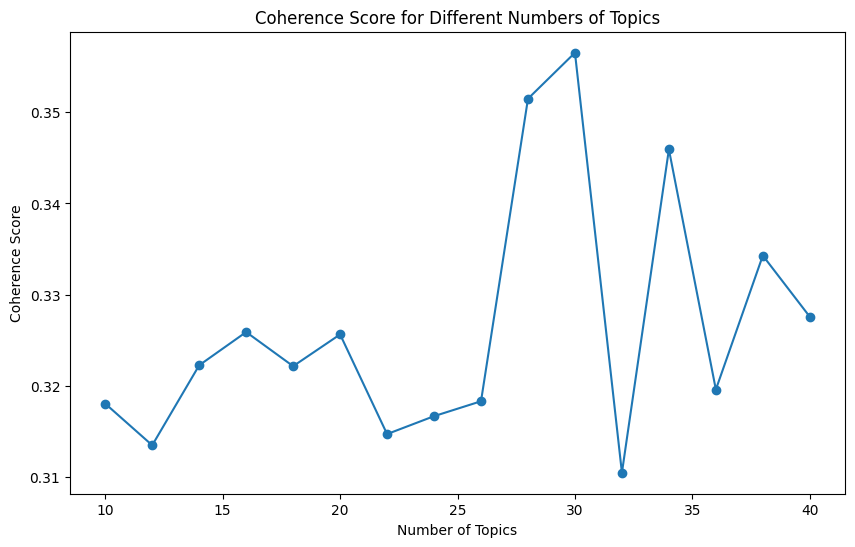

In [ ]:
# build dict n corpus
dict = corpora.Dictionary(unique_games['tokens'])
corpus = [dict.doc2bow(tokens) for tokens in unique_games['tokens']]

topic_range = range(10, 41, 2)  # Test topic counts 5, 10, 15, 20, 25, 30
coherence_scores = []

# train models and calculate coherence scores
for num_topics in topic_range:
    lda_model = models.LdaModel(corpus, num_topics=num_topics, id2word=dict, passes=10, random_state=42)

    # Coherence model
    coherence_model = CoherenceModel(model=lda_model, texts=unique_games['tokens'], dictionary=dict, coherence='c_v')
    coherence_score = coherence_model.get_coherence()

    coherence_scores.append((num_topics, coherence_score))
    print(f"Number of Topics: {num_topics}, Coherence Score: {coherence_score}")

# plot scores
topic_counts, scores = zip(*coherence_scores)
plt.figure(figsize=(10, 6))
plt.plot(topic_counts, scores, marker='o')
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Coherence Score for Different Numbers of Topics")
plt.show()

Coherence is highest when number of topics = 30, so we use num_topics = 30

In [ ]:
# train lda model
num_topics = 30
lda_model = models.LdaModel(corpus, num_topics=num_topics, id2word=dict, passes=25)

# test topics
print("\nTopics generated by LDA:")
for idx, topic in lda_model.print_topics(-1):
    print(f"Topic {idx + 1}: {topic}")

# Get topic distribution for each document
def get_topic_distribution(text):
    bow = dict.doc2bow(text)
    topic_dist = lda_model.get_document_topics(bow, minimum_probability=0)
    return [prob for _, prob in topic_dist]



Topics generated by LDA:
Topic 1: 0.010*"beat" + 0.008*"gungeon" + 0.007*"every" + 0.007*"choose" + 0.007*"world" + 0.007*"ship" + 0.006*"combat" + 0.006*"saber" + 0.006*"enter" + 0.005*"gun"
Topic 2: 0.015*"time" + 0.012*"new" + 0.010*"hat" + 0.007*"world" + 0.007*"around" + 0.006*"portia" + 0.006*"explore" + 0.006*"every" + 0.005*"enemy" + 0.005*"take"
Topic 3: 0.000*"world" + 0.000*"new" + 0.000*"character" + 0.000*"story" + 0.000*"hunter" + 0.000*"monster" + 0.000*"use" + 0.000*"weapon" + 0.000*"knight" + 0.000*"horror"
Topic 4: 0.025*"war" + 0.021*"world" + 0.019*"total" + 0.018*"warhammer" + 0.017*"battle" + 0.015*"race" + 0.014*"campaign" + 0.011*"legendary" + 0.010*"new" + 0.009*"fantasy"
Topic 5: 0.012*"eye" + 0.012*"hunting" + 0.010*"tracking" + 0.008*"take" + 0.008*"reserve" + 0.008*"trophy" + 0.008*"hacker" + 0.006*"environment" + 0.006*"unique" + 0.006*"weapon"
Topic 6: 0.011*"ark" + 0.008*"different" + 0.006*"tames" + 0.006*"item" + 0.006*"creature" + 0.006*"choose" + 0.

#### Applying the Topic Extraction for Each Game

In [ ]:
# apply topic distribution to each game
unique_games['topic_distribution'] = unique_games['tokens'].apply(get_topic_distribution)

# merge game topic back to reviews df
ncf_enriched_train = ncf_enriched_train.merge(unique_games[['item_encoded', 'topic_distribution']], on='item_encoded', how='left')
ncf_enriched_test = ncf_enriched_test.merge(unique_games[['item_encoded', 'topic_distribution']], on='item_encoded', how='left')

In [ ]:
# expand the probabilities to be 1 column for each topic
topic_columns = [f"topic_{i+1}" for i in range(num_topics)]

# expand for train
train_topics_df = pd.DataFrame(ncf_enriched_train['topic_distribution'].tolist(), columns=topic_columns)
ncf_enriched_train = pd.concat([ncf_enriched_train, train_topics_df], axis=1)

# expand for test
test_topics_df = pd.DataFrame(ncf_enriched_test['topic_distribution'].tolist(), columns=topic_columns)
ncf_enriched_test = pd.concat([ncf_enriched_test, test_topics_df], axis=1)



### Initalise DataLoaders

In [ ]:
item_cols = encoded_cols + numerical_cols + [f"topic_{i + 1}" for i in range(30)]

In [ ]:
class SteamReviewsDataset(Dataset):
    def __init__(self, df):
        self.user_ids = torch.tensor(df['user_encoded'].values, dtype=torch.long)
        self.item_ids = torch.tensor(df['item_encoded'].values, dtype=torch.long)
        self.labels = torch.tensor(df['recommended'].values, dtype=torch.float32)

        # Item-specific features
        self.item_features = torch.tensor(df[item_cols].values, dtype=torch.float32)


    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return (self.user_ids[idx], self.item_ids[idx], self.item_features[idx], self.labels[idx])

In [ ]:
batch_size=256

train_dataset = SteamReviewsDataset(ncf_enriched_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = SteamReviewsDataset(ncf_enriched_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

### Initialise Model

In [ ]:
class NCF_Enriched(nn.Module):
    def __init__(self, num_users, num_items, embedding_dim=64, num_item_features=num_item_features):
        super(NCF_Enriched, self).__init__()

        # Embedding layers for GMF and MLP
        self.user_embedding_gmf = nn.Embedding(num_users, embedding_dim)
        self.item_embedding_gmf = nn.Embedding(num_items, embedding_dim)
        self.user_embedding_mlp = nn.Embedding(num_users, embedding_dim)
        self.item_embedding_mlp = nn.Embedding(num_items, embedding_dim)

        # MLP input size: embeddings + user-item features + item features
        mlp_input_size = 2 * embedding_dim + num_item_features

        # mlp layers
        self.mlp_layer1 = nn.Linear(mlp_input_size, 128)
        self.mlp_relu1 = nn.ReLU()

        self.mlp_layer2 = nn.Linear(128, 64)
        self.mlp_relu2 = nn.ReLU()

        self.mlp_layer3 = nn.Linear(64, 32)
        self.mlp_relu3 = nn.ReLU()

        # final layer combining GMF and MLP
        combined_input_size = embedding_dim + 32 # GMF + last mlp layer size
        self.fc1 = nn.Linear(combined_input_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, user_id, item_id, item_features):
        # GMF component
        user_emb_gmf = self.user_embedding_gmf(user_id)
        item_emb_gmf = self.item_embedding_gmf(item_id)
        gmf_output = user_emb_gmf * item_emb_gmf  # Element-wise multiplication

        # MLP component
        user_emb_mlp = self.user_embedding_mlp(user_id)
        item_emb_mlp = self.item_embedding_mlp(item_id)

        # Concatenate embeddings, user-item features, and item features for MLP input
        mlp_input = torch.cat([user_emb_mlp, item_emb_mlp, item_features], dim=-1)

        # pass thru mlp layers
        mlp_output = self.mlp_layer1(mlp_input)
        mlp_output = self.mlp_relu1(mlp_output)

        mlp_output = self.mlp_layer2(mlp_output)
        mlp_output = self.mlp_relu2(mlp_output)

        mlp_output = self.mlp_layer3(mlp_output)
        mlp_output = self.mlp_relu3(mlp_output)

        # Combine GMF and MLP outputs for final prediction
        combined_output = torch.cat([gmf_output, mlp_output], dim=-1)
        output = self.fc1(combined_output)
        output = self.sigmoid(output)  # Sigmoid for binary classification

        return output.squeeze()


### Model Training and Test Loss

In [ ]:
num_users = train['user_encoded'].nunique()
num_items = train['item_encoded'].nunique()
num_item_features = len(item_cols)
embedding_dim = 64
lr=0.001
num_epochs=10
k=10

ncf_enriched = NCF_Enriched(
    num_users=num_users,
    num_items=num_items,
    embedding_dim=embedding_dim,
    num_item_features=num_item_features)

optimizer = torch.optim.Adam(ncf_enriched.parameters(), lr=lr)
criterion = nn.BCELoss()


for epoch in range(num_epochs):
    ncf_enriched.train()
    epoch_loss = 0

    for user_ids, item_ids, item_features, labels in train_loader:

        optimizer.zero_grad()
        outputs = ncf_enriched(user_ids, item_ids, item_features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss / len(train_loader)}')

ncf_enriched.eval()
with torch.no_grad():
    total_loss = 0
    for user_ids, item_ids, item_features, labels in test_loader:

        outputs = ncf_enriched(user_ids, item_ids, item_features)
        loss = criterion(outputs, labels)

        total_loss += loss.item()

    print(f'Test Loss: {total_loss / len(test_loader)}')

Epoch 1/10, Loss: 0.41408456311361425
Epoch 2/10, Loss: 0.36642370421141
Epoch 3/10, Loss: 0.3283779627669997
Epoch 4/10, Loss: 0.29988264879669024
Epoch 5/10, Loss: 0.27848972649691334
Epoch 6/10, Loss: 0.25875020057964077
Epoch 7/10, Loss: 0.23904024453434217
Epoch 8/10, Loss: 0.21499307692358968
Epoch 9/10, Loss: 0.18874695034606204
Epoch 10/10, Loss: 0.16150588815603453
Test Loss: 0.555660945145744


### Model Evaluation
Using Precision@K, Recall@K, F1, NDCG

K is set at 4 as test set will minimally have 4 games per user

#### Predict Unseen Games for users

Based on learned interactions in trainset, model predicts games to recommend to user & user must not have played these games before

In [ ]:
# dictionary of users and their interacted items in the trainset
user_to_games = {}

for user in ncf_enriched_train['user_encoded'].unique():
    interacted_items = set(ncf_enriched_train[ncf_enriched_train['user_encoded'] == user]['item_encoded']) # games that user interacted with
    user_to_games[user] = interacted_items

# dictionary of items and their item features
items_features = {}
for game in ncf_enriched_train['item_encoded'].unique():
    game_features = ncf_enriched_train[ncf_enriched_train['item_encoded']== game][item_cols].values[0]
    items_features[game] = torch.tensor(game_features, dtype=torch.float32)  # Store as tensor

# lists to store model recommendation
all_recommendations = []
all_actuals = []
all_items = set(ncf_enriched_train['item_encoded'].unique()) # we can do this as train and test contains all games

# number of top recommendations
top_k = 4

In [ ]:
ncf_baseline.eval()

with torch.no_grad():
    for user in test['user_encoded'].unique():

        # get unseen games for this user
        unseen_items = list(all_items - user_to_games.get(user, set()))

        # create input tensors
        user_ids_tensor = torch.tensor([user] * len(unseen_items), dtype=torch.long)
        item_ids_tensor = torch.tensor(unseen_items, dtype=torch.long)

        # retrieve item features for the unseen items
        unseen_item_features = [items_features[item] for item in unseen_items]
        unseen_item_features_tensor = torch.stack(unseen_item_features)  # stack

        # generate predictions for this user
        predictions = ncf_enriched(user_ids_tensor, item_ids_tensor, unseen_item_features_tensor).squeeze().numpy()

        # get top k indices
        top_k_indices = predictions.argsort()[-top_k:][::-1]  # sort by probability, higher -> more likely for user to like
        recommended_items = [unseen_items[idx] for idx in top_k_indices]

        # retrieve actual interacted items from the test set
        actual_items = ncf_enriched_test[ncf_enriched_test['user_encoded'] == user]['item_encoded'].tolist()

        # sgofd recommendations and actuals for evaluation
        all_recommendations.append(recommended_items)
        all_actuals.append(actual_items)

# evaluate recommendations by comparing with actual interactions
for user, recs, actuals in zip(ncf_enriched_test['user_encoded'].unique(), all_recommendations, all_actuals):
    print(f"User {user} Recommendations: {recs}")
    print(f"User {user} Actuals: {actuals}")


User 0 Recommendations: [64, 151, 22, 131]
User 0 Actuals: [156, 129, 33, 91]
User 1 Recommendations: [143, 151, 158, 48]
User 1 Actuals: [39, 31, 29, 2, 106, 14, 149, 33, 95, 76, 159]
User 2 Recommendations: [151, 48, 88, 45]
User 2 Actuals: [165, 115, 87, 66, 97]
User 3 Recommendations: [122, 143, 64, 45]
User 3 Actuals: [14, 128, 36, 28, 66, 119, 81, 122]
User 4 Recommendations: [17, 64, 104, 121]
User 4 Actuals: [145, 82, 154, 151, 159, 121]
User 5 Recommendations: [48, 151, 165, 3]
User 5 Actuals: [119, 132, 110, 116, 152]
User 6 Recommendations: [64, 41, 60, 131]
User 6 Actuals: [15, 143, 48, 119, 45, 60]
User 7 Recommendations: [119, 121, 40, 42]
User 7 Actuals: [99, 70, 163, 8]
User 8 Recommendations: [22, 143, 3, 158]
User 8 Actuals: [29, 55, 160, 83, 147]
User 9 Recommendations: [143, 149, 165, 64]
User 9 Actuals: [121, 74, 80, 53, 84]
User 10 Recommendations: [64, 42, 93, 18]
User 10 Actuals: [73, 113, 153, 133, 49, 90, 115, 47]
User 11 Recommendations: [18, 93, 48, 94]
User

In [ ]:
# function to calculate metrics@k
def calculate_metrics_for_user(actual, recommended, k=4):
    actual_set = set(actual)
    recommended_at_k = recommended[:k]

    # Precision@K
    hits_at_k = sum(1 for item in recommended_at_k if item in actual_set)
    precision_at_k = hits_at_k / k

    # Recall@K
    recall_at_k = hits_at_k / len(actual_set) if actual_set else 0

    # F1@K
    f1_at_k = (2 * precision_at_k * recall_at_k) / (precision_at_k + recall_at_k) if (precision_at_k + recall_at_k) > 0 else 0

    # NDCG@K
    dcg = sum(1 / np.log2(idx + 2) for idx, item in enumerate(recommended_at_k) if item in actual_set)
    idcg = sum(1 / np.log2(idx + 2) for idx in range(min(len(actual_set), k)))
    ndcg_at_k = dcg / idcg if idcg > 0 else 0

    return precision_at_k, recall_at_k, f1_at_k, ndcg_at_k

# aggregate metrics
def calculate_aggregated_metrics(all_actuals, all_recommendations, k=4):
    precision_list = []
    recall_list = []
    f1_list = []
    ndcg_list = []

    for actual, recommended in zip(all_actuals, all_recommendations):
        precision_at_k, recall_at_k, f1_at_k, ndcg_at_k = calculate_metrics_for_user(actual, recommended, k)
        precision_list.append(precision_at_k)
        recall_list.append(recall_at_k)
        f1_list.append(f1_at_k)
        ndcg_list.append(ndcg_at_k)

    # average metrics across all users
    metrics = {
        'Precision': np.mean(precision_list),
        'Recall': np.mean(recall_list),
        'F1 Score': np.mean(f1_list),
        'NDCG': np.mean(ndcg_list)
    }

    return metrics



In [ ]:
metrics = calculate_aggregated_metrics(all_actuals, all_recommendations, k=4)


print(f"Overall Precision@4: {metrics['Precision']:.4f}")
print(f"Recall@4: {metrics['Recall']:.4f}")
print(f"F1@4: {metrics['F1 Score']:.4f}")
print(f"NDCG@4: {metrics['NDCG']:.4f}")

Overall Precision@4: 0.0450
Recall@4: 0.0326
F1@4: 0.0374
NDCG@4: 0.0469
